### __eBOSS - $p_k$ with $2$ sky-cuts__
Comparison between samples generated with the *westcoast* (WC) prior setup or the *eastcoast* (EC) prior setup. Both apply a gaussian BBN-related prior on $\omega_b$.

In [1]:
# Import modules and set up plotting
from python_scripts.support import *
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Define chain folder
chain_dir = os.path.join(os.getcwd(), 'chains/')

__1. Loading the data__

In [2]:
# First distributions: eBOSS + BBN Prior
posterior1 = loadMCSamples(file_root=chain_dir+'efteboss_wc_std/posterior', settings={'ignore_rows':0.})
posterior1.name_tag = 'eBOSS WC'
prior1 = loadMCSamples(file_root=chain_dir+'efteboss_wc_std/prior', settings={'ignore_rows':0.})
prior1.name_tag = 'eBOSS WC Prior'
# Get the parameter limits
param_limits1 = pd.read_csv(chain_dir+'efteboss_wc_std/param_limits.csv', index_col=0)
# Convert to dictionary
param_limits1 = param_limits1.to_dict()
for key in param_limits1.keys():
    param_limits1[key] = (param_limits1[key][0], param_limits1[key][1])

# Second distributions: eBOSS + BBN Prior
posterior2 = loadMCSamples(file_root=chain_dir+'efteboss_ec_std/posterior', settings={'ignore_rows':0.})
posterior2.name_tag = 'eBOSS EC'
prior2 = loadMCSamples(file_root=chain_dir+'efteboss_ec_std/prior', settings={'ignore_rows':0.})
prior2.name_tag = 'eBOSS EC Prior'
# Get the parameter limits
param_limits2 = pd.read_csv(chain_dir+'efteboss_ec_std/param_limits.csv', index_col=0)
# Convert to dictionary
param_limits2 = param_limits2.to_dict()
for key in param_limits2.keys():
    param_limits2[key] = (param_limits2[key][0], param_limits2[key][1])

# Define the cosmological and nuisance parameter names and labels
params1 = posterior1.getParamNames().list()
labels1 = posterior1.getLatex()[0]
params2 = posterior2.getParamNames().list()
labels2 = posterior2.getLatex()[0]
# Exclude A_s to avoid degeneracy with sigma_8
# Exclude Omega_m from the cosmological parameter list to avoid degeneracy with omega_cdm, 
# omega_b and h
params1 = [param for param in params1 if ('A' not in param) and ('Omega' not in param)]
labels1 = [label for label in labels1 if ('A' not in label and ('Omega' not in label))]
params2 = [param for param in params2 if ('A' not in param) and ('Omega' not in param)]
labels2 = [label for label in labels2 if ('A' not in label) and ('Omega' not in label)]
# Define the nuisance parameter names and labels
nuisance_params1 = params1[4:12]
nuisance_labels1 = labels1[4:12]
nuisance_params2 = params2[4:10]
nuisance_labels2 = labels2[4:10]
# Define the cosmological parameter names and labels: the cosmological parameters are the same,
# while each chain has different nuisance parameters 
cosmo_params = [param for param in params1 if param not in nuisance_params1]
cosmo_labels = [label for label in labels1 if label not in nuisance_labels1]

__2. Transforming to logarithmic scale__\
Unfortunately, EFT priors have negative values and so we can not transform these parameters to logarithmic scale.

In [3]:
# Parameters to be transformed to logarithmic scale
params_tolog = [param for param in cosmo_params if param != 'ln10^{10}A_s']
# Define the labels based on the index of the parameters to be transformed
labels_tolog = [cosmo_labels[cosmo_params.index(param)] for param in params_tolog]
# Transform these parameters to logarithmic scale
for chain in [posterior1, prior1, posterior2, prior2]:
    log_params, log_labels = log_transform(chain, params_tolog, labels_tolog)

In [4]:
# Since we are going to use log-params, add the nuisance parameters to this list
log_params1 = log_params + nuisance_params1
log_labels1 = log_labels + nuisance_labels1
log_params2 = log_params + nuisance_params2
log_labels2 = log_labels + nuisance_labels2

__3 CPCA decomposition__

N_eff 	= 10.53

Improvement factor over the prior:
 [1837.85 1637.93 1334.45  816.69   52.1    29.69   23.     21.98   13.83
    5.62    4.85    1.15    0.99]
Discarding error units due to negative values.


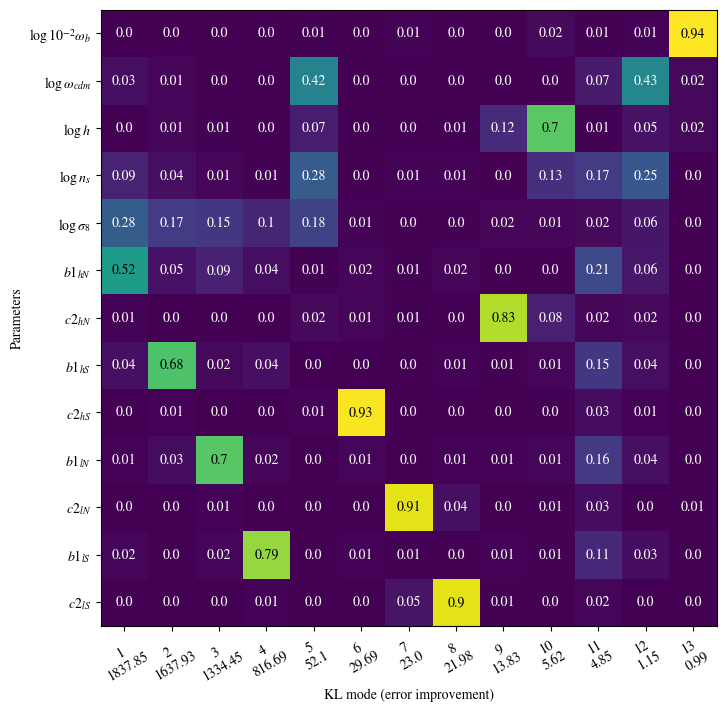

In [5]:
# Plot the fractional CPCA loading matrix on the WC chain
KL_eig1, KL_eigv1, KL_param_names1 = plot_frac_fisher(prior_chain=prior1, posterior_chain=posterior1, 
                                                      params=log_params1, labels=log_labels1,
                                                      norm=True, figsize=8, print_improvement=True)

N_eff 	= 4.7008

Improvement factor over the prior:
 [543.82 307.86  14.31   3.14   1.93   1.47   1.26   1.05   1.04   0.97
   0.87]
Discarding error units due to negative values.


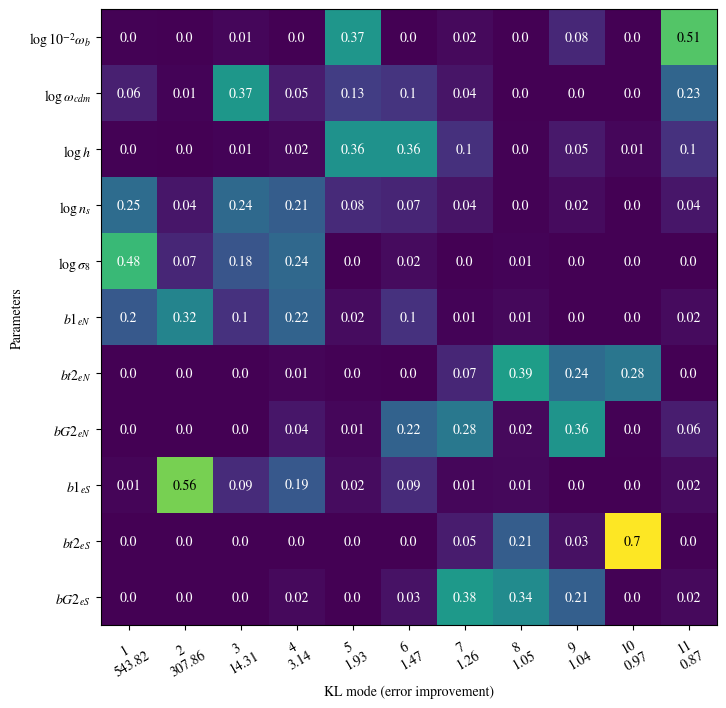

In [6]:
# Do the same on the EC data
KL_eig2, KL_eigv2, KL_param_names2 = plot_frac_fisher(prior_chain=prior2, posterior_chain=posterior2, 
                                                      params=log_params2, labels=log_labels2,
                                                      norm=True, figsize=8, print_improvement=True)

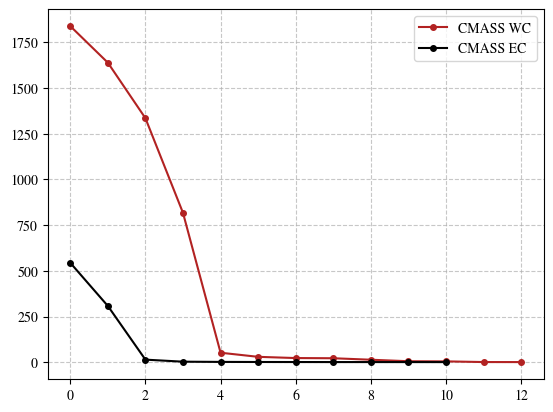

In [7]:
# Plot the scree plot for both datasets: no need to normalize since the eigenvalues are dimensionless
plt.plot(KL_eig1, 'o-', markersize=4, color='firebrick', label='CMASS WC')
plt.plot(KL_eig2, 'o-', markersize=4, color='k', label='CMASS EC')

# Set the legend and the grid
plt.legend()
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show();

<font size=3>

*__Note__: based on the previous scree plot, we add the first 5 modes to the WC configuration and the first 3 modes to the EC configuration.*

__4.1 Prior Shrinking__

In [8]:
# Push the prior contribution to 0 on the eBOSS WC data
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
posterior_mean = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1])
inv_KL_eigv1 = np.linalg.inv(KL_eigv1)
# Only keeping the first 11 modes
inv_KL_eigv1[11:,:] = 0.
# Project the shifted posterior samples on the KL modes
KL_filtered_samples1 = np.dot(np.dot(posterior1.samples[:,idx]-prior_mean, KL_eigv1), inv_KL_eigv1)+prior_mean

# Prior Shrinking - Cosmological Parameters
KL_chain1 = MCSamples(samples=KL_filtered_samples1, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=KL_param_names1, 
                     labels=[name.label for name in posterior1.getParamNames().parsWithNames(KL_param_names1)], 
                     label='KL-eBOSS WC',
                     settings={'ignore_rows':0.})

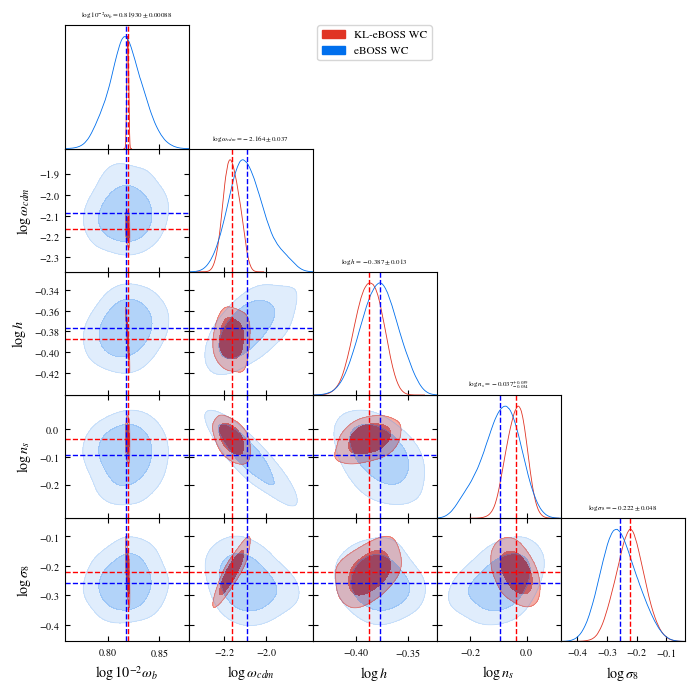

In [9]:
# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain1, posterior1], params=KL_param_names1[:5], filled=True, title_limit=1)
KL_means1 = KL_chain1.getMeans(pars=[KL_chain1.index[name] for name in KL_param_names1[:5]])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1[:5]])
# Display mean indicators
for i in range(len(KL_param_names1[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axvline(means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axhline(means[i], color='blue', lw=1., ls='--')

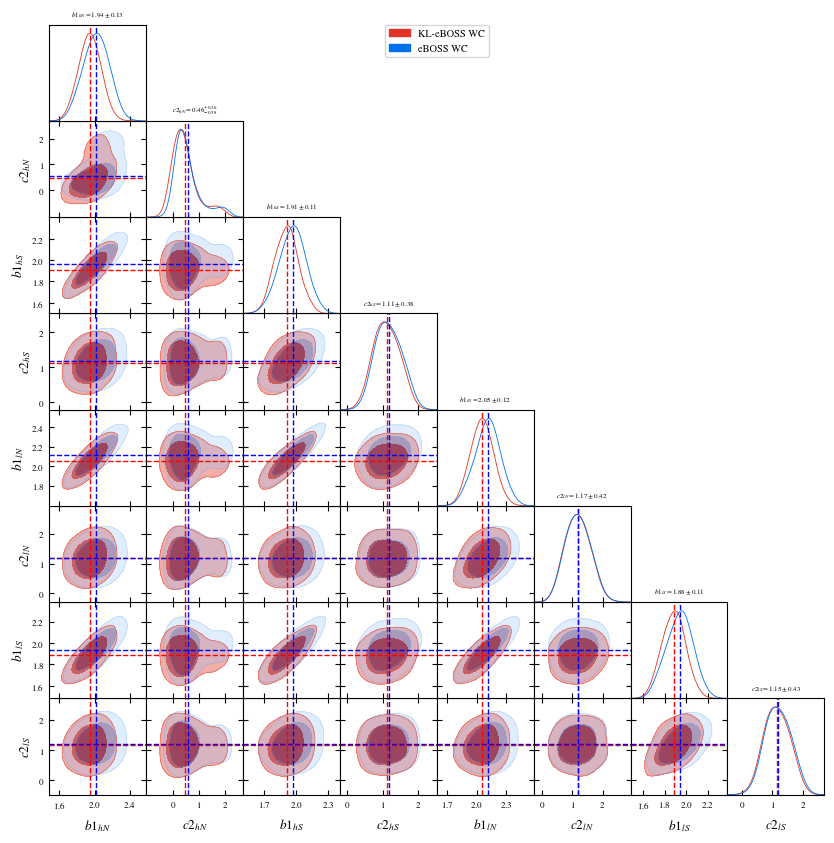

In [10]:
# Plot the nuisance parameters
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain1, posterior1], params=KL_param_names1[5:], filled=True, title_limit=1)
KL_means1 = KL_chain1.getMeans(pars=[KL_chain1.index[name] for name in KL_param_names1[5:]])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1[5:]])
# Display mean indicators
for i in range(len(KL_param_names1[5:])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axvline(means[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means1[i], color='red', lw=1., ls='--')
        ax.axhline(means[i], color='blue', lw=1., ls='--')

*Note*: very good overlap on the distributions of $h$, $\sigma_8$ and the EFT nuisance parameters.\
On the other hand, the KL-distribution of $\omega_b$ is considerably squeezed by the BBN prior.

In particular, $c_2$ four sky-cuts appear to be uneffected by the prior distribution, resulting in a KL-projected distribution almost identical to the original one. In fact, the prior on $c_2$ is Gaussian, with zero mean and variance $2$: as we see in the plot above, the posteriors differ considerably from this distribution.

In [11]:
# Push the prior contribution to 0 on the eBOSS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean2 = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
posterior_mean2 = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2])
inv_KL_eigv2 = np.linalg.inv(KL_eigv2)
# Only keeping the first 5 modes
inv_KL_eigv2[5:,:] = 0.
# Project the shifted posterior samples on the KL modes
KL_filtered_samples2 = np.dot(np.dot(posterior2.samples[:,idx]-prior_mean2, KL_eigv2), inv_KL_eigv2)+prior_mean2

# Prior Shrinking - Cosmological Parameters
KL_chain2 = MCSamples(samples=KL_filtered_samples2, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=KL_param_names2, 
                     labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                     label='KL-eBOSS EC',
                     settings={'ignore_rows':0.})

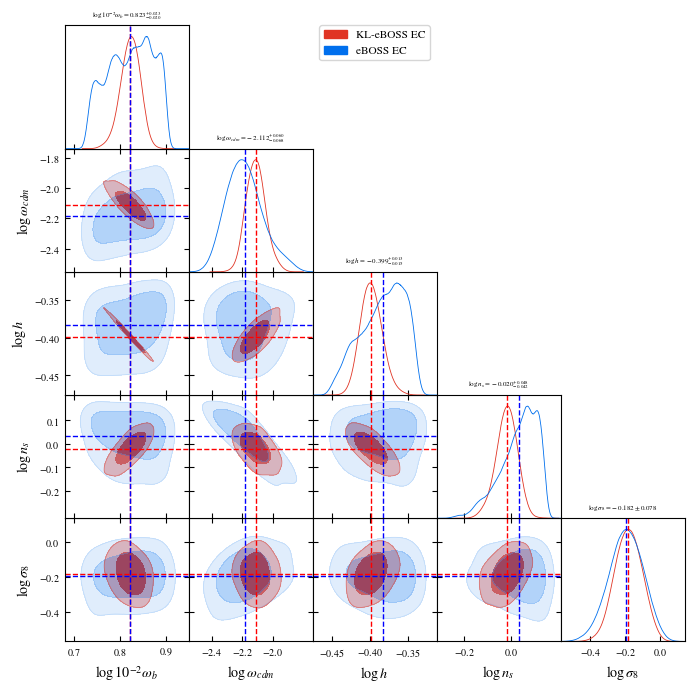

In [12]:
# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain2, posterior2], params=KL_param_names2[:5], filled=True, title_limit=1)
KL_means2 = KL_chain2.getMeans(pars=[KL_chain2.index[name] for name in KL_param_names2[:5]])
means2 = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[:5]])
# Display mean indicators
for i in range(len(KL_param_names2[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axvline(means2[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axhline(means2[i], color='blue', lw=1., ls='--')

*Note*: $\omega_b$ seems to be less prior-constrained. However, looking at the $h-\omega_b$ plane, we notice that a combination of the two parameters is strictly constrained.

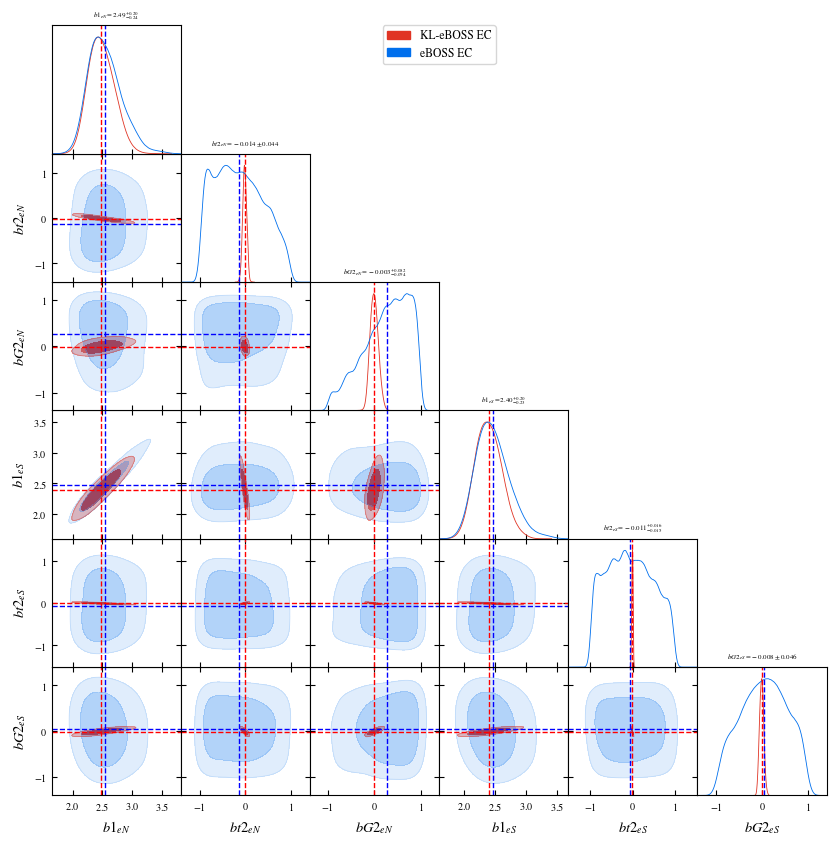

In [13]:
# Plot the nuisance parameters
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
# The titles refer to the mean values of the KL posterior distributions
g.triangle_plot([KL_chain2, posterior2], params=KL_param_names2[5:], filled=True, title_limit=1)
KL_means2 = KL_chain2.getMeans(pars=[KL_chain2.index[name] for name in KL_param_names2[5:]])
means2 = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[5:]])
# Display mean indicators
for i in range(len(KL_param_names2[5:])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axvline(means2[i], color='blue', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means2[i], color='red', lw=1., ls='--')
        ax.axhline(means2[i], color='blue', lw=1., ls='--')

*Note*: Here the situation is different: while the two components of $b_1$ appear to be well overlapping, those of $bt_2$ and $bG_2$ seem to suffer considerably from the prior, showing much narrower KL-distributions than the original ones.

Once again, the EC configuration seems to be more restrictive on the constraints to the bias parameters.

__4.2 Prior Explosion__\
Here, by exploding the first $11$ modes' prior contributions, we get very wide KL posteriors. So we perform a search for *problematic* modes. 

*__1. Select the first 11 modes__*: large and degenerate KL-distributions.

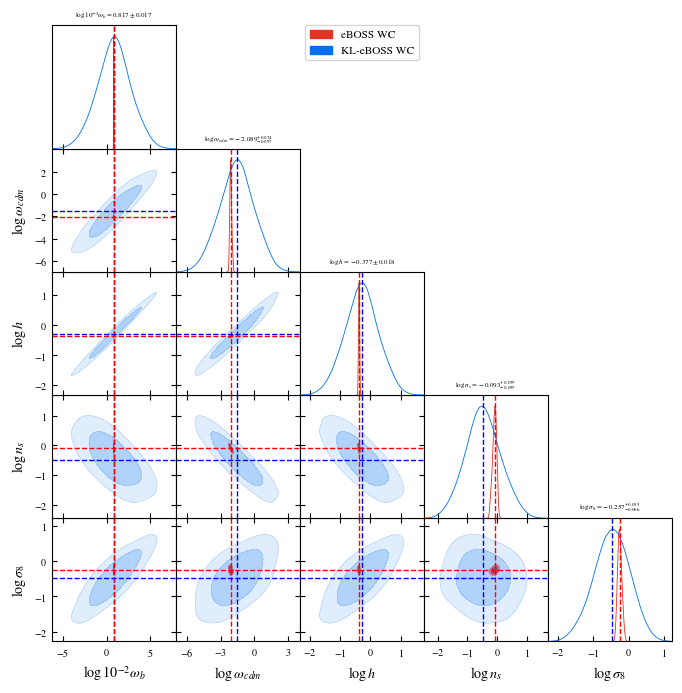

In [14]:
# Push the prior contribution to infinity on the eBOSS WC data
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
inv_KL_eigv = np.linalg.inv(KL_eigv1)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv1 = 1./KL_eig1
# Selecting the first 11 modes
KL_eig_inv1[:11] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv1)), 
                                    np.dot(KL_eigv1.T, (posterior1.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv1)*KL_eig_inv1), 
                                                                                          np.dot(KL_eigv1.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp1 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=KL_param_names1, 
                     labels=[name.label for name in posterior1.getParamNames().parsWithNames(KL_param_names1)], 
                     label='KL-eBOSS WC',
                     settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior1, KL_chain_exp1], params=KL_param_names1[:5], filled=True, title_limit=1);
KL_means = KL_chain_exp1.getMeans(pars=[KL_chain_exp1.index[name] for name in KL_param_names1[:5]])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1[:5]])
# Display mean indicators
for i in range(len(KL_param_names1[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

*__2. Select only the last 2 modes__*: almost perfect overlapping between KL-projected and original distributions.

Actually, the biggest difference can be seen after the introduction of the last mode, which, from the CPCA matrix, is almost completely informed by $\omega_b$. The BBN prior on this parameter is therefore very relevant.

In [15]:
# Push the prior contribution to infinity on the eBOSS WC data
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
inv_KL_eigv = np.linalg.inv(KL_eigv1)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv1 = 1./KL_eig1
# Selecting all the modes
KL_eig_inv1[-2:] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv1)), 
                                    np.dot(KL_eigv1.T, (posterior1.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv1)*KL_eig_inv1), 
                                                                                          np.dot(KL_eigv1.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp1 = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=KL_param_names1, 
                     labels=[name.label for name in posterior1.getParamNames().parsWithNames(KL_param_names1)], 
                     label='KL-eBOSS WC',
                     settings={'ignore_rows':0.})

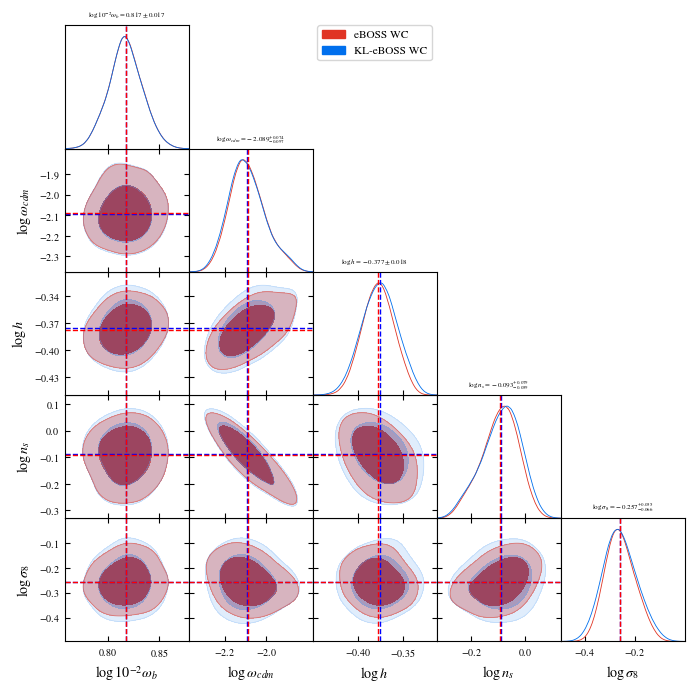

In [16]:
# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior1, KL_chain_exp1], params=KL_param_names1[:5], filled=True, title_limit=1);
KL_means = KL_chain_exp1.getMeans(pars=[KL_chain_exp1.index[name] for name in KL_param_names1[:5]])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1[:5]])
# Display mean indicators
for i in range(len(KL_param_names1[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

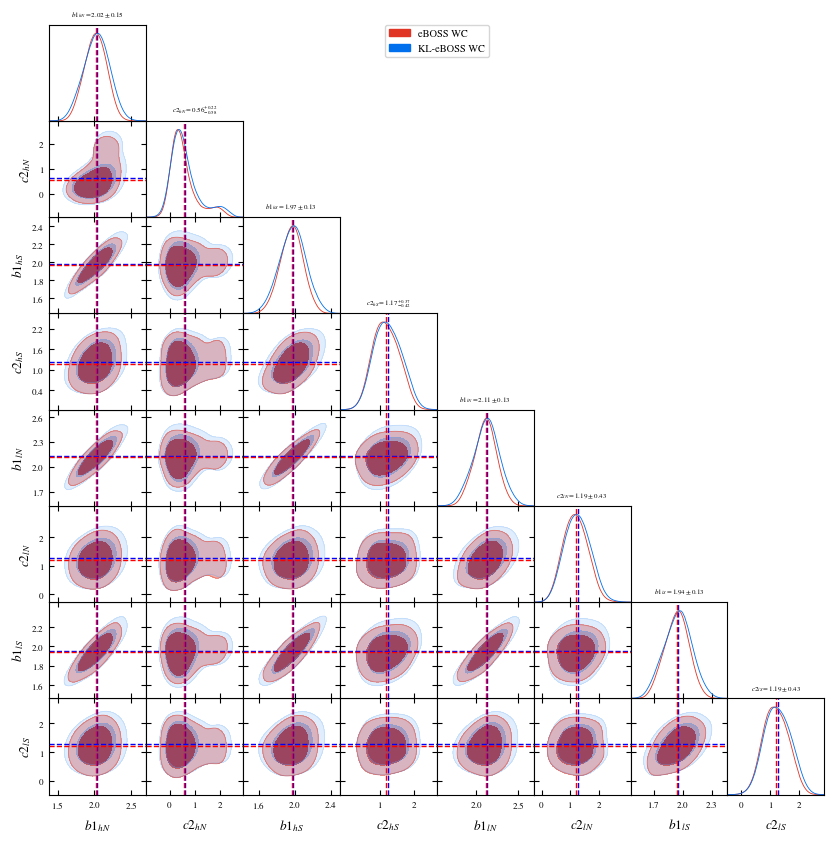

In [17]:
# Plot the nuisance parameters
g = plots.get_subplot_plotter(width_inch=10)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior1, KL_chain_exp1], params=KL_param_names1[5:], filled=True, title_limit=1);
KL_means = KL_chain_exp1.getMeans(pars=[KL_chain_exp1.index[name] for name in KL_param_names1[5:]])
means = posterior1.getMeans(pars=[posterior1.index[name] for name in KL_param_names1[5:]])
# Display mean indicators
for i in range(len(KL_param_names1[5:])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

The EC setup also presents problems with prior explosion.

__*1. Select the first 5 modes*__: large and degenerate KL distributions.

In [18]:
# Push the prior contribution to infinity on the eBOSS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv2 = 1./KL_eig2
KL_eig_inv2[:5] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples,
                        loglikes=posterior2.loglikes, 
                        weights=posterior2.weights, 
                        names=KL_param_names2, 
                        labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                        label='KL-eBOSS EC',
                        settings={'ignore_rows':0.})

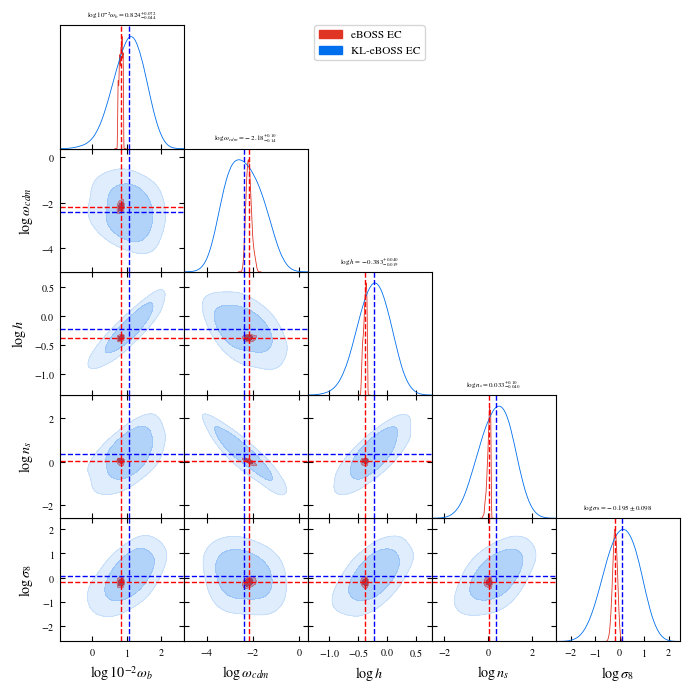

In [19]:
# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2[:5], filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2[:5]])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[:5]])
# Display mean indicators
for i in range(len(KL_param_names2[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

__*2. Select the last 2 modes*__: no significant difference.

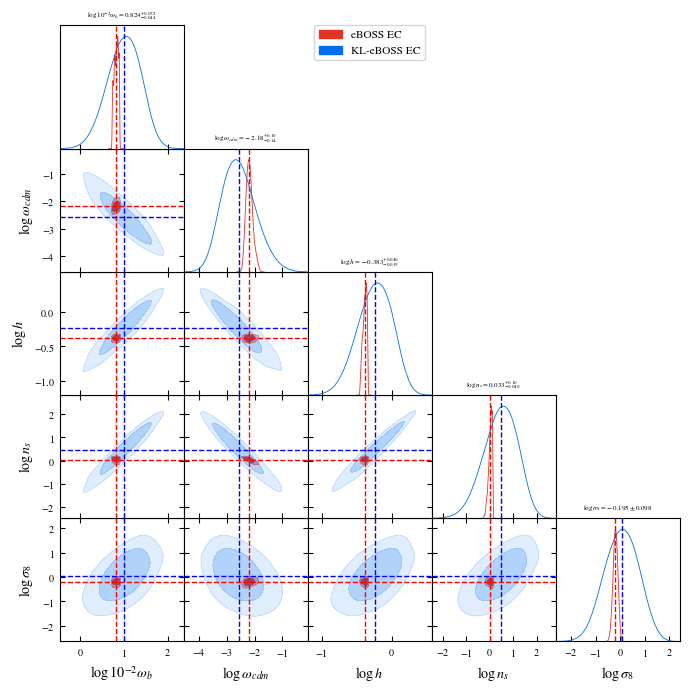

In [20]:
# Push the prior contribution to infinity on the eBOSS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv2 = 1./KL_eig2
KL_eig_inv2[-2:] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples,
                        loglikes=posterior2.loglikes, 
                        weights=posterior2.weights, 
                        names=KL_param_names2, 
                        labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                        label='KL-eBOSS EC',
                        settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2[:5], filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2[:5]])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[:5]])
# Display mean indicators
for i in range(len(KL_param_names2[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

__*3. Select the last 4 modes*__: the distributions look in better agreement $^{[1]}$.

<font size = 2>

$^{[1]}$ : we jumped two modes because both produce a clearly visible difference on the KL posteriors.

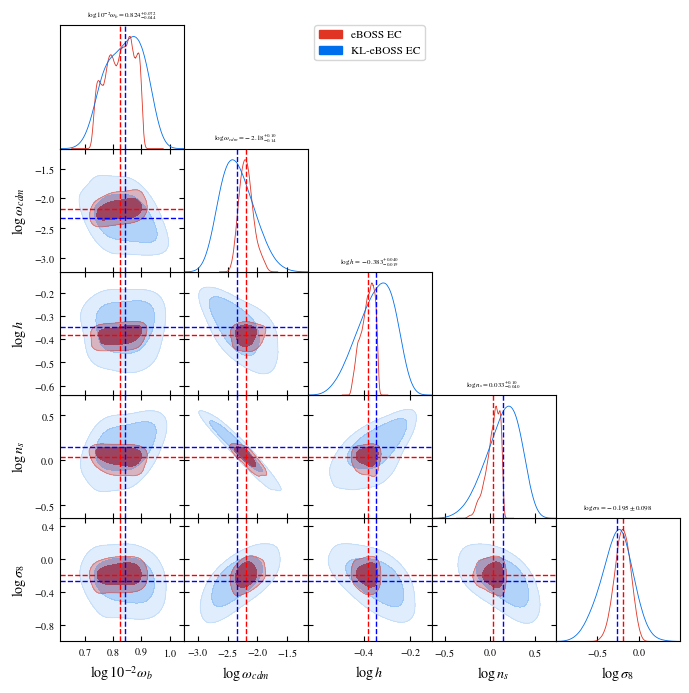

In [21]:
# Push the prior contribution to infinity on the eBOSS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
inv_KL_eigv = np.linalg.inv(KL_eigv2)
# Invert the values then send them to 0: this is equivalent to set them to infinity
KL_eig_inv2 = 1./KL_eig2
KL_eig_inv2[-4:] = 0.
KL_filtered_samples = np.dot(np.dot(np.diag(1./(1.-KL_eig_inv2)), 
                                    np.dot(KL_eigv2.T, (posterior2.samples[:,idx]).T)).T-np.dot(np.diag(1./(1.-KL_eig_inv2)*KL_eig_inv2), 
                                                                                          np.dot(KL_eigv2.T, prior_mean)), 
                                    inv_KL_eigv)
# Define the new chain
KL_chain_exp2 = MCSamples(samples=KL_filtered_samples,
                        loglikes=posterior2.loglikes, 
                        weights=posterior2.weights, 
                        names=KL_param_names2, 
                        labels=[name.label for name in posterior2.getParamNames().parsWithNames(KL_param_names2)], 
                        label='KL-eBOSS EC',
                        settings={'ignore_rows':0.})

# Plot the cosmological parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2[:5], filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2[:5]])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[:5]])
# Display mean indicators
for i in range(len(KL_param_names2[:5])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

*Note*: looking at the associated CPCA matrix, we see that modes 8 and 9 are mainly informed by the sky-cuts of the bias parameters $bt_2$ and $bG_2$. As in the case of CMASS, the prior on these parameters takes on a certain relevance.

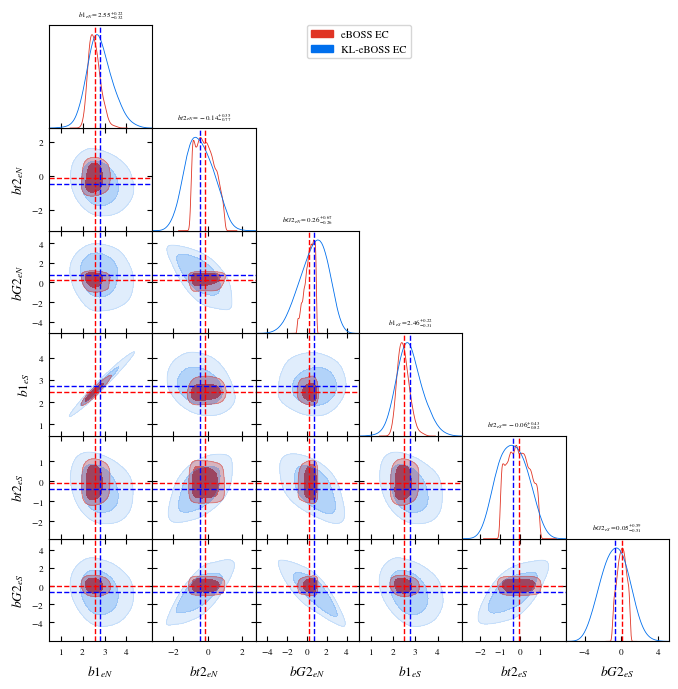

In [22]:
# Plot the nuisance parameters
g = plots.get_subplot_plotter(width_inch=8)
g.settings.alpha_filled_add = 0.3
g.settings.title_limit_fontsize = 0.8
g.triangle_plot([posterior2, KL_chain_exp2], params=KL_param_names2[5:], filled=True, title_limit=1);
KL_means = KL_chain_exp2.getMeans(pars=[KL_chain_exp2.index[name] for name in KL_param_names2[5:]])
means = posterior2.getMeans(pars=[posterior2.index[name] for name in KL_param_names2[5:]])
# Display mean indicators
for i in range(len(KL_param_names2[5:])):
    # Fix the column, change the row -> decreasing from len(cosmo_params)
    for ax in g.subplots[i:,i]:
        ax.axvline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axvline(means[i], color='red', lw=1., ls='--')
    # Fix the row, change the column -> increasing from 0
    for ax in g.subplots[i,:i]:
        ax.axhline(KL_means[i], color='blue', lw=1., ls='--')
        ax.axhline(means[i], color='red', lw=1., ls='--')

__4.3 Prior and posterior comparison__\
Here we project the posterior and prior distributions on the KL modes (without removing or exploding the prior contribution): higher similarity between the two distributions means higher prior information level.

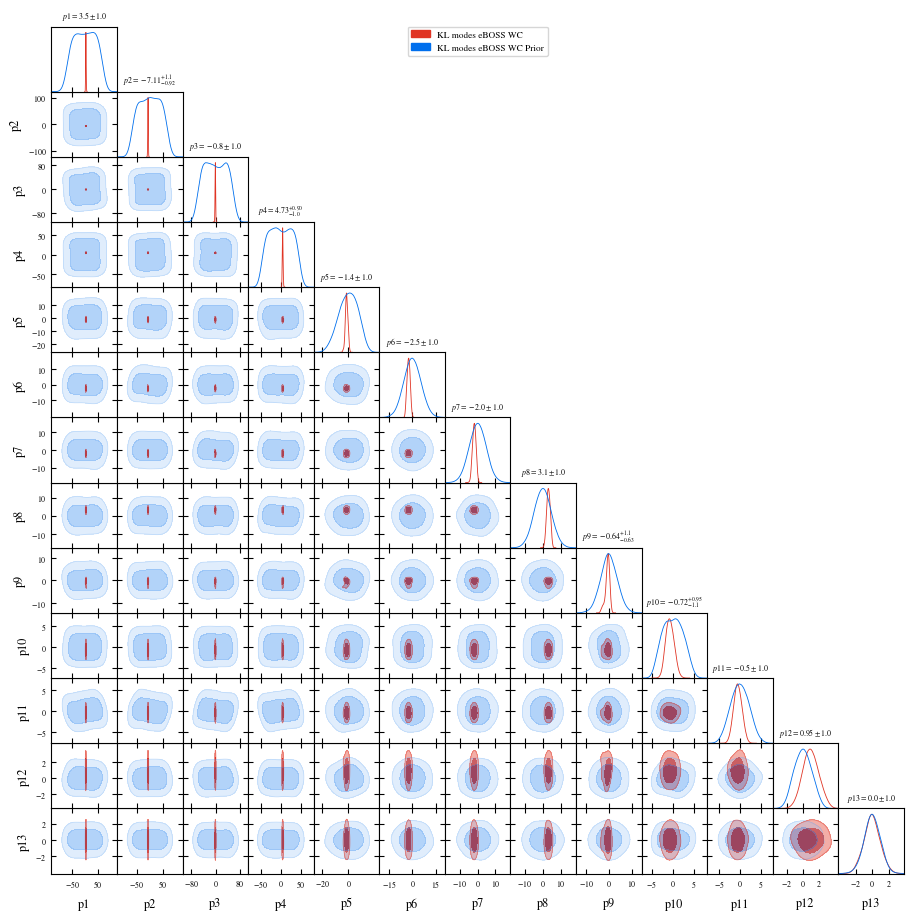

In [23]:
# KL decomposition on the posterior
idx = [posterior1.index[name] for name in KL_param_names1]
prior_mean = prior1.getMeans(pars=[prior1.index[name] for name in KL_param_names1])
temp_names = [f'p{str(i+1)}' for i in range(len(KL_param_names1))]
# Project the shifted posterior samples on the KL modes
KL_filtered_samples = np.dot(posterior1.samples[:,idx] - prior_mean, KL_eigv1)
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior1.loglikes, 
                     weights=posterior1.weights, 
                     names=temp_names, 
                     label='KL modes eBOSS WC')
# KL decomposition on the prior
idx = [prior1.index[name] for name in KL_param_names1]
# Project the shifted prior samples on the KL modes
KL_filtered_prior_samples = np.dot(prior1.samples[:,idx] - prior_mean, KL_eigv1)
KL_prior_chain = MCSamples(samples=KL_filtered_prior_samples, 
                     loglikes=prior1.loglikes, 
                     weights=prior1.weights, 
                     names=temp_names, 
                     label='KL modes eBOSS WC Prior')
# Plot the KL modes
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.triangle_plot([KL_chain, KL_prior_chain], params=temp_names, 
                filled=True, title_limit=1);

*Note*: the last two modes are definitely wider than the previous ones.

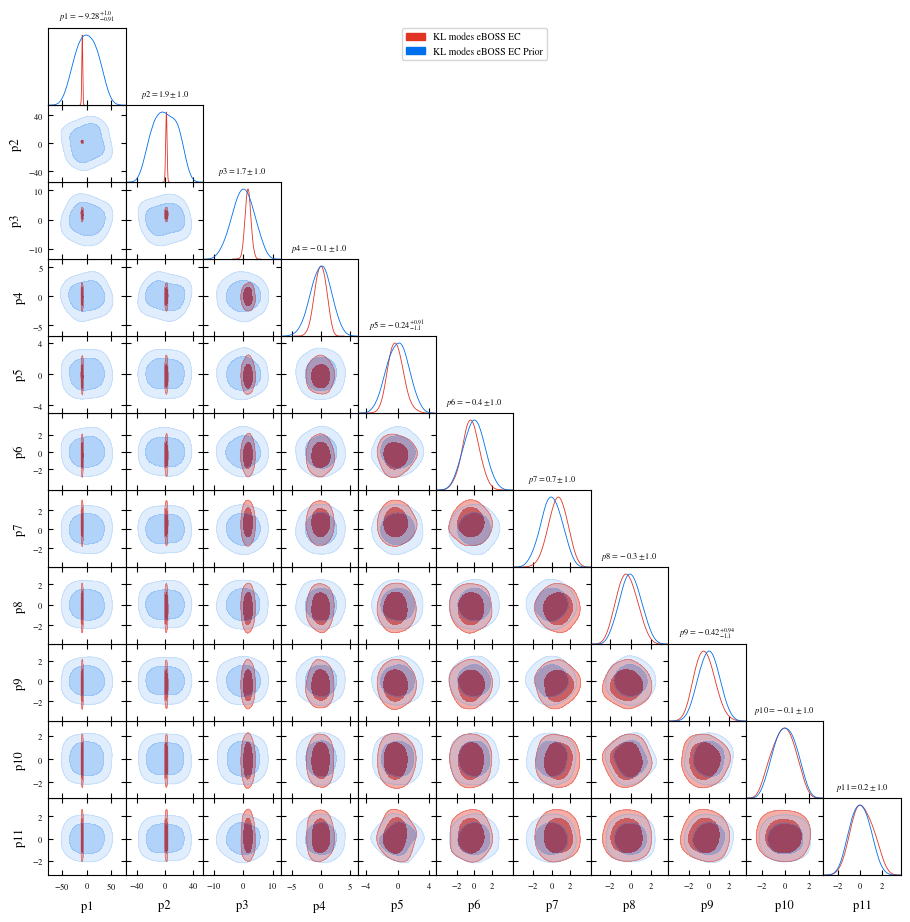

In [24]:
# Repeat the process for the eBOSS EC data
idx = [posterior2.index[name] for name in KL_param_names2]
prior_mean = prior2.getMeans(pars=[prior2.index[name] for name in KL_param_names2])
temp_names = [f'p{str(i+1)}' for i in range(len(KL_param_names2))]
# Project the shifted posterior samples on the KL modes
KL_filtered_samples = np.dot(posterior2.samples[:,idx] - prior_mean, KL_eigv2)
KL_chain = MCSamples(samples=KL_filtered_samples, 
                     loglikes=posterior2.loglikes, 
                     weights=posterior2.weights, 
                     names=temp_names, 
                     label='KL modes eBOSS EC')
# KL decomposition on the prior
idx = [prior2.index[name] for name in KL_param_names2]
# Project the shifted prior samples on the KL modes
KL_filtered_prior_samples = np.dot(prior2.samples[:,idx] - prior_mean, KL_eigv2)
KL_prior_chain = MCSamples(samples=KL_filtered_prior_samples, 
                     loglikes=prior2.loglikes, 
                     weights=prior2.weights, 
                     names=temp_names, 
                     label='KL modes eBOSS EC Prior')
# Plot the KL modes
g = plots.get_subplot_plotter(width_inch=11)
g.settings.alpha_filled_add = 0.3
g.triangle_plot([KL_chain, KL_prior_chain], params=temp_names, 
                filled=True, title_limit=1);

*Note*: here we start to notice a posterior widening at mode $4$.

__5. Best-constrained parameters__

In [25]:
from tensiometer_dev.tensiometer import *
# Print CPC parameter combinations
dict1 = gaussian_tension.linear_CPCA_chains(prior1, posterior1, param_names=log_params1)
dict2 = gaussian_tension.linear_CPCA_chains(prior2, posterior2, param_names=log_params2)

# Define the start and end string delimiting the text to be printed
start = 'CPC parameter combinations:'
end = 'CPC modes parameters correlations'
s = gaussian_tension.print_CPCA_results(dict1)
print('eBOSS WC CPC Parameter Combinations', end=' ')
print(s[s.find(start)+len(start):s.rfind(end)])
s = gaussian_tension.print_CPCA_results(dict2)
print('\n\neBOSS EC CPC Parameter Combinations', end=' ')
print(s[s.find(start)+len(start):s.rfind(end)])

eBOSS WC CPC Parameter Combinations 
   1 : 1836.847 (  4285.8 %)
      +2.39*(\log \sigma_8 +0.26) +1.00*(b1_{hN } -2.02) = 0 +- 0.028 (post) / 1.2 (prior)
   2 : 1636.928 (  4045.9 %)
      +1.85*(\log \sigma_8 +0.26) +1.00*(b1_{hS } -1.97) = 0 +- 0.029 (post) / 1.2 (prior)
   3 : 1333.454 (  3651.6 %)
      +1.74*(\log \sigma_8 +0.26) +1.00*(b1_{lN } -2.11) = 0 +- 0.033 (post) / 1.2 (prior)
   4 :  815.693 (  2856.0 %)
      +1.00*(b1_{lS } -1.94) = 0 +- 0.042 (post) / 1.2 (prior)
   5 :   51.105 (   714.9 %)
      +1.00*(\log \omega{}_{cdm } +2.09) +1.07*(\log n_{s } +0.09) -0.06*(\log \sigma_8 +0.26) = 0 +- 0.034 (post) / 0.24 (prior)
   6 :   28.688 (   535.6 %)
      +1.00*(c2_{hS } -1.17) = 0 +- 0.38 (post) / 2.1 (prior)
   7 :   22.003 (   469.1 %)
      +1.00*(c2_{lN } -1.19) = 0 +- 0.43 (post) / 2.1 (prior)
   8 :   20.983 (   458.1 %)
      +1.00*(c2_{lS } -1.19) = 0 +- 0.45 (post) / 2.1 (prior)
   9 :   12.832 (   358.2 %)
      -14.59*(\log h +0.38) +1.00*(c2_{hN } -0.56)

In [26]:
# Use the first mode to project both datasets. Notice that the first mode is equivalent
# Add the derived parameters (new modes) to a copy of the original chain
temp_chain1 = posterior1.copy()
temp_chain2 = posterior2.copy()
p1 = temp_chain1.getParams()
p2 = temp_chain2.getParams()

# Add the new parameters to the first chain
temp_chain1.addDerived(p1.sigma8**2.39 * np.exp(p1.b1_hN),
                        name='p1', label='p_1 = \sigma_8^{2.39} \mathcal{e}^{b1_{hN}}')
temp_chain1.addDerived(p1.sigma8**1.85 * np.exp(p1.b1_hS),
                        name='p2', label='p_2 = \sigma_8^{1.85} \mathcal{e}^{b1_{hS}}')
temp_chain1.addDerived(p1.sigma8**1.74 * np.exp(p1.b1_lN),
                        name='p3', label='p_3 = \sigma_8^{1.74} \mathcal{e}^{b1_{lN}}')
temp_chain1.addDerived(np.exp(p1.b1_lS),
                        name='p4', label='p_4 = \mathcal{e}^{b1_{lS}}')
temp_chain1.addDerived(p1.omega_cdm * p1.n_s**1.07 * p1.sigma8**-0.06,
                        name='p5', label='p_5 = \\frac{\omega_{cdm} n_s}{\sigma_8^{0.06}}')

# Add the new parameters to the second chain
temp_chain2.addDerived(p2.n_s**-0.87 * p2.sigma8**1.00 * np.exp(0.28*p2.b1_eN),
                        name='p1', label='p_1 = \\frac{\sigma_8 \mathcal{e}^{0.28b1_{eN}}}{n_s^{0.87}}')
temp_chain2.addDerived(np.exp(-0.45*p2.b1_eN + p2.b1_eS),
                        name='p2', label='p_2 = \mathcal{e}^{b1_{eS} - 0.45b1_{eN}}')
temp_chain2.addDerived(p2.omega_cdm**1.00 * p2.n_s**1.33 * p2.sigma8**0.11,
                        name='p3', label='p_3 = \omega_{cdm} n_s^{1.33} \sigma_8^{0.11}')

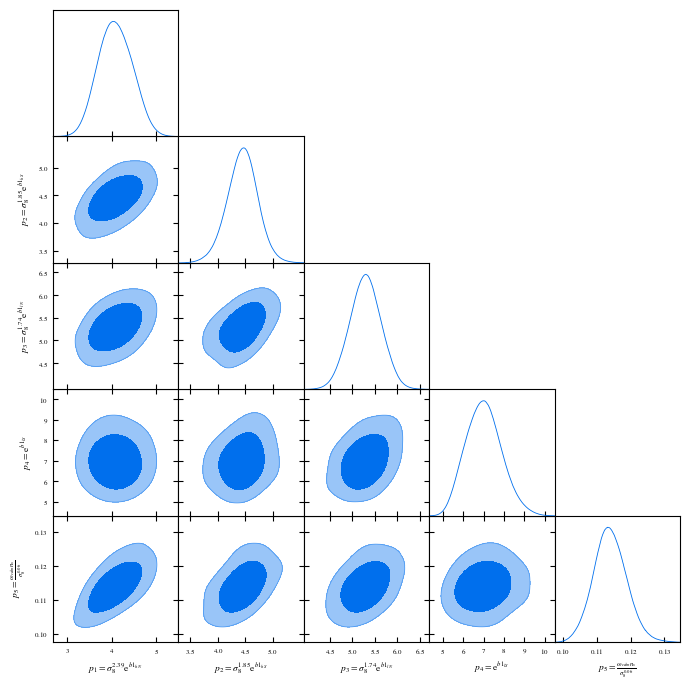

In [27]:
# Plot the new parameters
g = plots.get_subplot_plotter(width_inch=7)
g.settings.alpha_filled_add = 0.3
g.settings.axes_fontsize = 1
g.settings.axes_labelsize = 11
g.triangle_plot([temp_chain1], params=['p1', 'p2', 'p3', 'p4', 'p5'], filled=True)

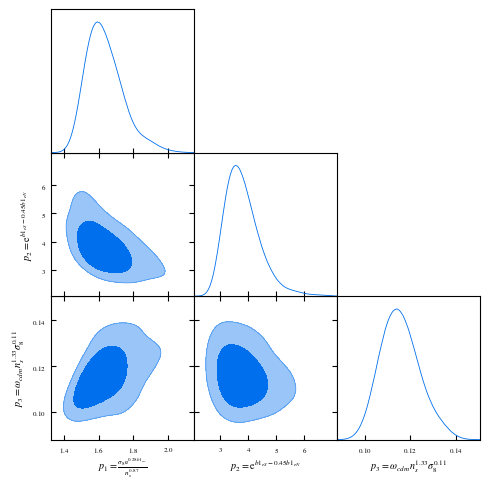

In [28]:
# Plot the new parameters (second chain)
g = plots.get_subplot_plotter(width_inch=5)
g.settings.alpha_filled_add = 0.3
g.settings.axes_fontsize = 1
g.settings.axes_labelsize = 11
g.triangle_plot([temp_chain2], params=['p1', 'p2', 'p3'], filled=True)

*Note*: Neither $c_2$ nor $b_2$ inform the first modes we selected.

The common parameters are $\omega_{cdm}$, $n_s$ and $\sigma_8$.

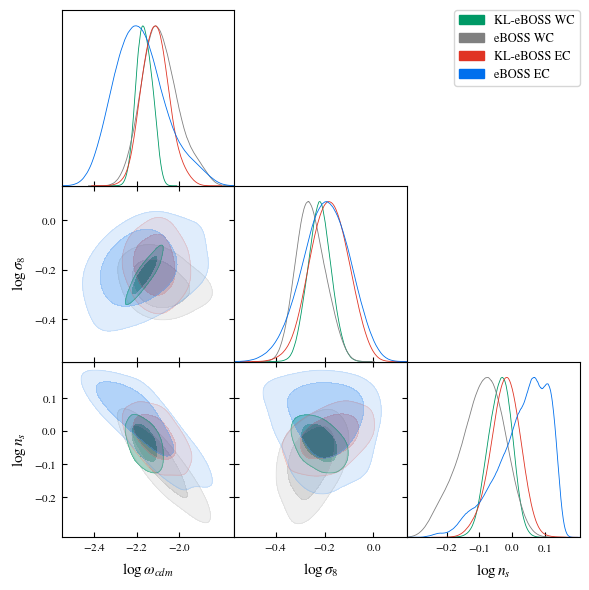

In [29]:
# Graphic evaluation
g = plots.get_subplot_plotter(width_inch=6)
g.settings.alpha_filled_add = 0.3
# Compare the KL-eBOSS WC/EC and the eBOSS WC/EC distributions for omega_cdm, sigma8 and n_s
# Here we use the prior shrinking
g.triangle_plot([KL_chain1, posterior1, KL_chain2, posterior2], 
                params=['log_omega_cdm', 'log_sigma8', 'log_n_s'], 
                filled=True)

*Note*: all three parameters show a certain discrepancy, considering the original distributions. They are mitigated by the prior removal. For example, look at how the two original $n_s$ distributions change after the prior removal.

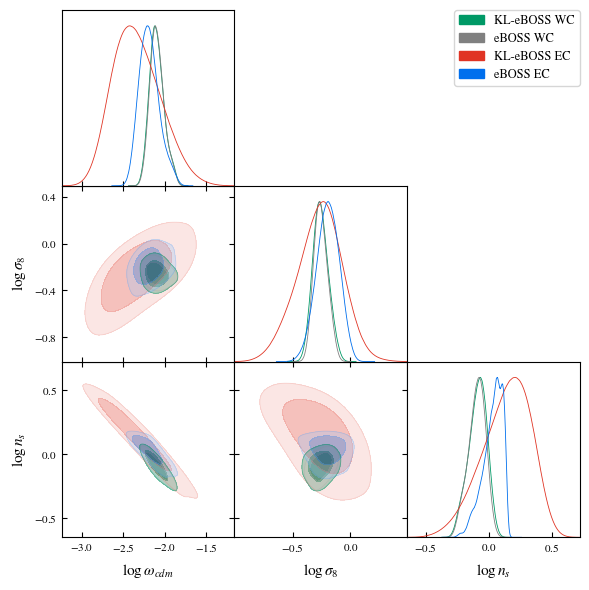

In [30]:
# Graphic evaluation
g = plots.get_subplot_plotter(width_inch=6)
g.settings.alpha_filled_add = 0.3
# Compare the KL-eBOSS WC/EC and the eBOSS WC/EC distributions for omega_cdm, sigma8 and n_s
# Here we use the prior explosion
g.triangle_plot([KL_chain_exp1, posterior1, KL_chain_exp2, posterior2], 
                params=['log_omega_cdm', 'log_sigma8', 'log_n_s'], 
                filled=True)

*Note*: exploding just the two last modes produced very overlapping WC distributions.\
The prior explosion, contrarily, distances the distributions and emphasises the effect of the prior.

In [31]:
# Function to get the best-fit values
def get_best_fit(posterior=None, params=None):
    # Get the best-fit values as a Latex string array
    best_fit = posterior.getLatex(params=params)[1]
    # Get the means
    means = posterior.getMeans(pars=[posterior.index[name] for name in params])
    # Initialize the lower and upper bounds
    lower = np.zeros(len(params))
    upper = np.zeros(len(params))
    # Get the lower and upper bounds
    for i in range(len(params)):
        # If there is the \pm symbol in the string, we have just one value
        if '\pm' in best_fit[i]:
            # Get the value
            upper[i] = float(best_fit[i].split(' ')[1])
            lower[i] = -float(best_fit[i].split(' ')[1])
        else:
            # The lower bound is the first value inside the {} brackets
            upper[i] = float(best_fit[i].split('{')[1].split('}')[0])
            # The upper bound is the second value inside the {} brackets
            lower[i] = float(best_fit[i].split('{')[2].split('}')[0])

    # Put the means, the lower and upper values inside a DataFrame
    return pd.DataFrame(data={'Mean':means, 'Lower':np.abs(lower), 'Upper':upper}, index=params)

In [33]:
# Compare the results using the procedure described above
df_best_fit1 = get_best_fit(posterior1, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
df_best_fit2 = get_best_fit(posterior2, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
df_best_fit['sigma-'] = np.sqrt(df_best_fit['WC Lower']**2 + df_best_fit['EC Lower']**2)
df_best_fit['sigma+'] = np.sqrt(df_best_fit['WC Upper']**2 + df_best_fit['EC Upper']**2)
# Divide by the sum of the errors
df_best_fit['z-'] = df_best_fit['Delta']/df_best_fit['sigma-']
df_best_fit['z+'] = df_best_fit['Delta']/df_best_fit['sigma+']
df_best_fit['z_avg'] = df_best_fit['Delta']/(np.sqrt((0.5*(df_best_fit['sigma-']+df_best_fit['sigma+'])**2)))

In [34]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,sigma-,sigma+,z-,z+,z_avg
log_omega_cdm,-2.088989,0.097,0.074,-2.184420,0.140,0.100,0.095430,0.170320,0.124403,0.560300,0.767109,0.457918
log_sigma8,-0.257066,0.066,0.055,-0.195463,0.098,0.098,0.061603,0.118152,0.112379,0.521385,0.548172,0.377908
log_n_s,-0.093283,0.059,0.079,0.033339,0.040,0.100,0.126622,0.071281,0.127440,1.776382,0.993584,0.901118


In [35]:
# Repeat the process for the KL chains
df_best_fit1 = get_best_fit(KL_chain1, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
df_best_fit2 = get_best_fit(KL_chain2, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
df_best_fit['sigma-'] = np.sqrt(df_best_fit['WC Lower']**2 + df_best_fit['EC Lower']**2)
df_best_fit['sigma+'] = np.sqrt(df_best_fit['WC Upper']**2 + df_best_fit['EC Upper']**2)
# Divide by the sum of the errors
df_best_fit['z-'] = df_best_fit['Delta']/df_best_fit['sigma-']
df_best_fit['z+'] = df_best_fit['Delta']/df_best_fit['sigma+']
df_best_fit['z_avg'] = df_best_fit['Delta']/(np.sqrt((0.5*(df_best_fit['sigma-']+df_best_fit['sigma+'])**2)))

In [36]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,sigma-,sigma+,z-,z+,z_avg
log_omega_cdm,-2.163976,0.037,0.037,-2.111941,0.068,0.060,0.052035,0.077414,0.070491,0.672161,0.738178,0.497537
log_sigma8,-0.221921,0.048,0.048,-0.182151,0.078,0.078,0.039770,0.091586,0.091586,0.434237,0.434237,0.307052
log_n_s,-0.036703,0.034,0.039,-0.020264,0.042,0.048,0.016439,0.054037,0.061847,0.304210,0.265797,0.200613


In [37]:
# Compare the results using the Confidence Interval Overlap
df_best_fit1 = get_best_fit(posterior1, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
df_best_fit2 = get_best_fit(posterior2, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
# Compute the percentage difference
df_best_fit['Delta %'] = 100.*df_best_fit['Delta']/np.sqrt(df_best_fit['WC Mean']**2 + df_best_fit['EC Mean']**2)
# Compute the percentage overlap
wc_lower = df_best_fit['WC Mean'] - df_best_fit['WC Lower']
wc_upper = df_best_fit['WC Upper'] + df_best_fit['WC Mean']
ec_lower = df_best_fit['EC Mean'] - df_best_fit['EC Lower']
ec_upper = df_best_fit['EC Upper'] + df_best_fit['EC Mean']
for i in range(len(df_best_fit)):
    df_best_fit.loc[df_best_fit.index[i], 'Overlap'] = np.max([0, np.min([wc_upper[i], ec_upper[i]]) - np.max([wc_lower[i], ec_lower[i]])])
# Compute the percentage overlap, using only 3 numbers after the comma
df_best_fit['WC Overlap %'] = (100.*(df_best_fit['Overlap']/(wc_upper - wc_lower))).round(3)
df_best_fit['EC Overlap %'] = (100.*(df_best_fit['Overlap']/(ec_upper - ec_lower))).round(3)

In [38]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,Delta %,Overlap,WC Overlap %,EC Overlap %
log_omega_cdm,-2.088989,0.097,0.074,-2.184420,0.140,0.100,0.095430,3.157323,0.101570,59.397,42.321
log_sigma8,-0.257066,0.066,0.055,-0.195463,0.098,0.098,0.061603,19.075774,0.091397,75.535,46.631
log_n_s,-0.093283,0.059,0.079,0.033339,0.040,0.100,0.126622,127.821411,0.000000,0.000,0.000


In [39]:
# Repeat the process for the KL chains
df_best_fit1 = get_best_fit(KL_chain1, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
df_best_fit2 = get_best_fit(KL_chain2, ['log_omega_cdm', 'log_sigma8', 'log_n_s'])
# Concatenate the two DataFrames
df_best_fit = pd.concat([df_best_fit1, df_best_fit2], axis=1)
# Rename the columns
df_best_fit.columns = ['WC '+ col for col in df_best_fit.columns[:3]]+['EC '+ col for col in df_best_fit.columns[3:]]
# Compute the difference and the errors
df_best_fit['Delta'] = abs(df_best_fit['WC Mean'] - df_best_fit['EC Mean'])
# Compute the percentage difference
df_best_fit['Delta %'] = 100.*df_best_fit['Delta']/np.sqrt(df_best_fit['WC Mean']**2 + df_best_fit['EC Mean']**2)
# Compute the percentage overlap
wc_lower = df_best_fit['WC Mean'] - df_best_fit['WC Lower']
wc_upper = df_best_fit['WC Upper'] + df_best_fit['WC Mean']
ec_lower = df_best_fit['EC Mean'] - df_best_fit['EC Lower']
ec_upper = df_best_fit['EC Upper'] + df_best_fit['EC Mean']
for i in range(len(df_best_fit)):
    df_best_fit.loc[df_best_fit.index[i], 'Overlap'] = np.max([0, np.min([wc_upper[i], ec_upper[i]]) - np.max([wc_lower[i], ec_lower[i]])])
# Compute the percentage overlap, using only 3 numbers after the comma
df_best_fit['WC Overlap %'] = (100.*(df_best_fit['Overlap']/(wc_upper - wc_lower))).round(3)
df_best_fit['EC Overlap %'] = (100.*(df_best_fit['Overlap']/(ec_upper - ec_lower))).round(3)

In [40]:
df_best_fit

,WC Mean,WC Lower,WC Upper,EC Mean,EC Lower,EC Upper,Delta,Delta %,Overlap,WC Overlap %,EC Overlap %
log_omega_cdm,-2.163976,0.037,0.037,-2.111941,0.068,0.060,0.052035,1.720873,0.052965,71.574,41.379
log_sigma8,-0.221921,0.048,0.048,-0.182151,0.078,0.078,0.039770,13.852205,0.086230,89.823,55.276
log_n_s,-0.036703,0.034,0.039,-0.020264,0.042,0.048,0.016439,39.208949,0.064561,88.440,71.735


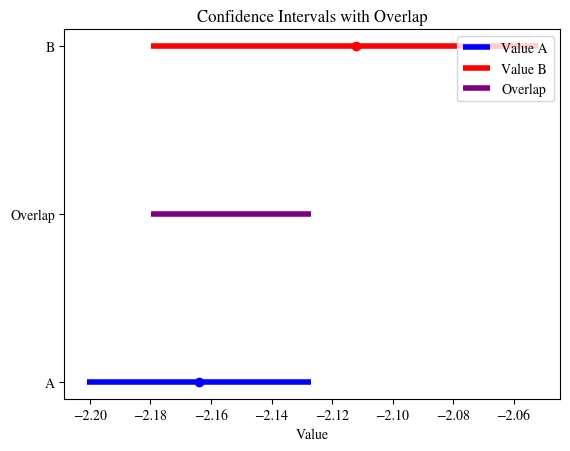

In [41]:
A_lower = (df_best_fit['WC Mean'] - df_best_fit['WC Lower'])[0]
A_upper = (df_best_fit['WC Mean'] + df_best_fit['WC Upper'])[0]
B_lower = (df_best_fit['EC Mean'] - df_best_fit['EC Lower'])[0]
B_upper = (df_best_fit['EC Mean'] + df_best_fit['EC Upper'])[0]

A = df_best_fit['WC Mean'][0]
B = df_best_fit['EC Mean'][0]

overlap_lower = max(A_lower, B_lower)
overlap_upper = min(A_upper, B_upper)
overlap_exists = overlap_lower < overlap_upper

# Plot the confidence intervals
fig, ax = plt.subplots()

# Plot A's confidence interval
ax.hlines(1, A_lower, A_upper, colors='blue', lw=4, label='Value A')
ax.plot(A, 1, 'bo')

# Plot B's confidence interval
ax.hlines(2, B_lower, B_upper, colors='red', lw=4, label='Value B')
ax.plot(B, 2, 'ro')

# Plot the overlapping region if it exists
if overlap_exists:
    ax.hlines(1.5, overlap_lower, overlap_upper, colors='purple', lw=4, label='Overlap')

# Draw lines at the ends of the confidence intervals
ax.hlines(1, A_lower, A_lower, colors='blue', lw=1)
ax.hlines(1, A_upper, A_upper, colors='blue', lw=1)
ax.hlines(2, B_lower, B_lower, colors='red', lw=1)
ax.hlines(2, B_upper, B_upper, colors='red', lw=1)

# Customize the plot
ax.set_yticks([1, 1.5, 2])
ax.set_yticklabels(['A', 'Overlap', 'B'])
ax.set_xlabel('Value')
ax.set_title('Confidence Intervals with Overlap')
ax.legend()

plt.show()

__6. Tension Estimates__

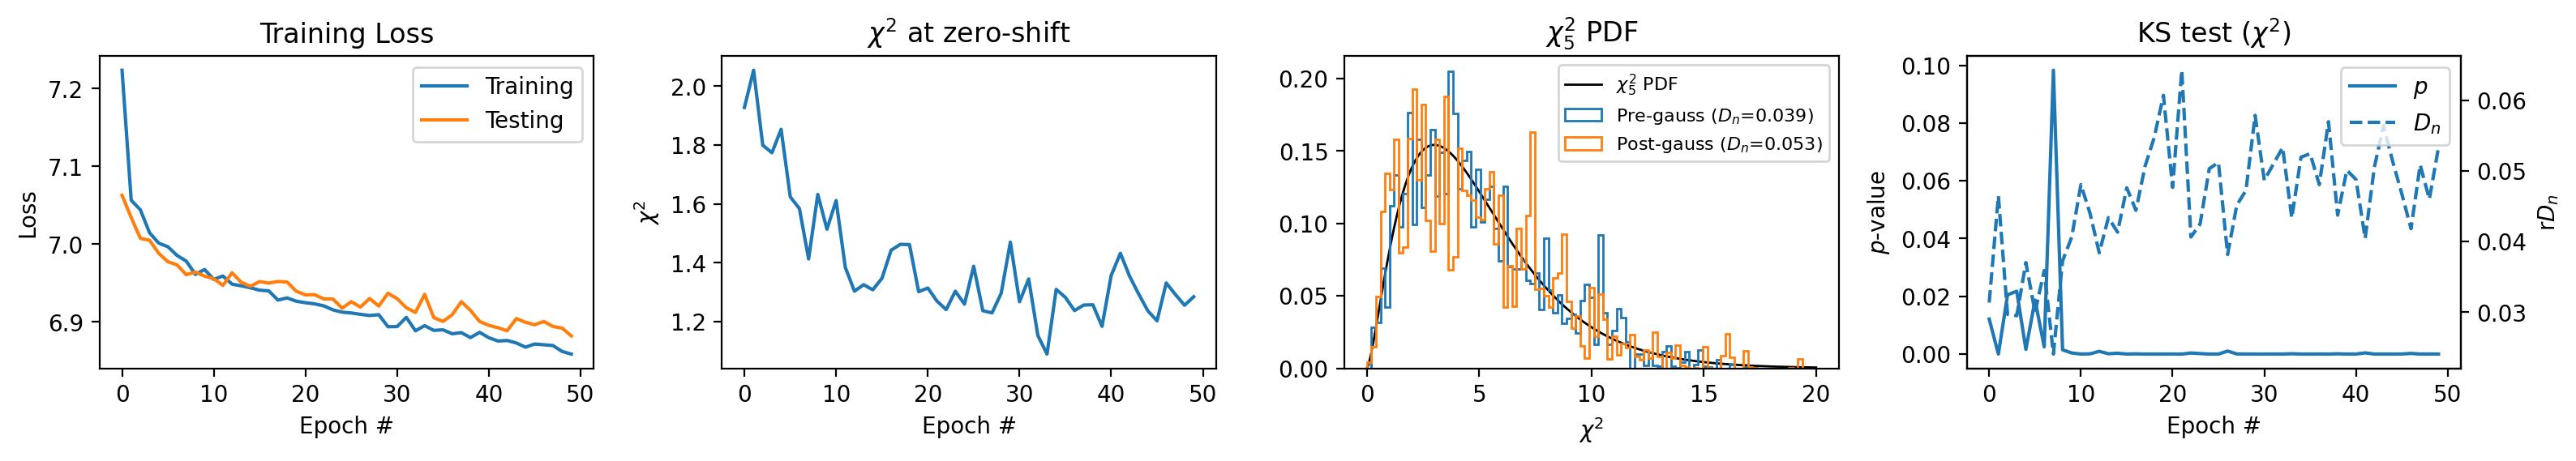

256/256 [==============================] - 8s 32ms/step - loss: 6.8587 - val_loss: 6.8820 - shift0_chi2: 1.2848 - shift0_pval: 0.0635 - shift0_nsigma: 0.0797 - chi2Z_ks: 0.0533 - chi2Z_ks_p: 7.9192e-07 - lr: 0.0010
Training completed.
Time taken to train the model: 428.407532453537 seconds


In [31]:
from python_scripts.flow import *
# Create a DiffFlow object
flow = DiffFlow(posterior1, posterior2, params=cosmo_params, labels=cosmo_labels)
# Build the difference chains
flow.build_diff()

# Train the Normalizing Flow model
# Print the time taken to train the model
import time
start = time.time()
flow.train(eta=0.001, epochs=50, batch_size=1024, steps_per_epoch=256)
end = time.time()
print('Time taken to train the model: {} seconds'.format(end-start))

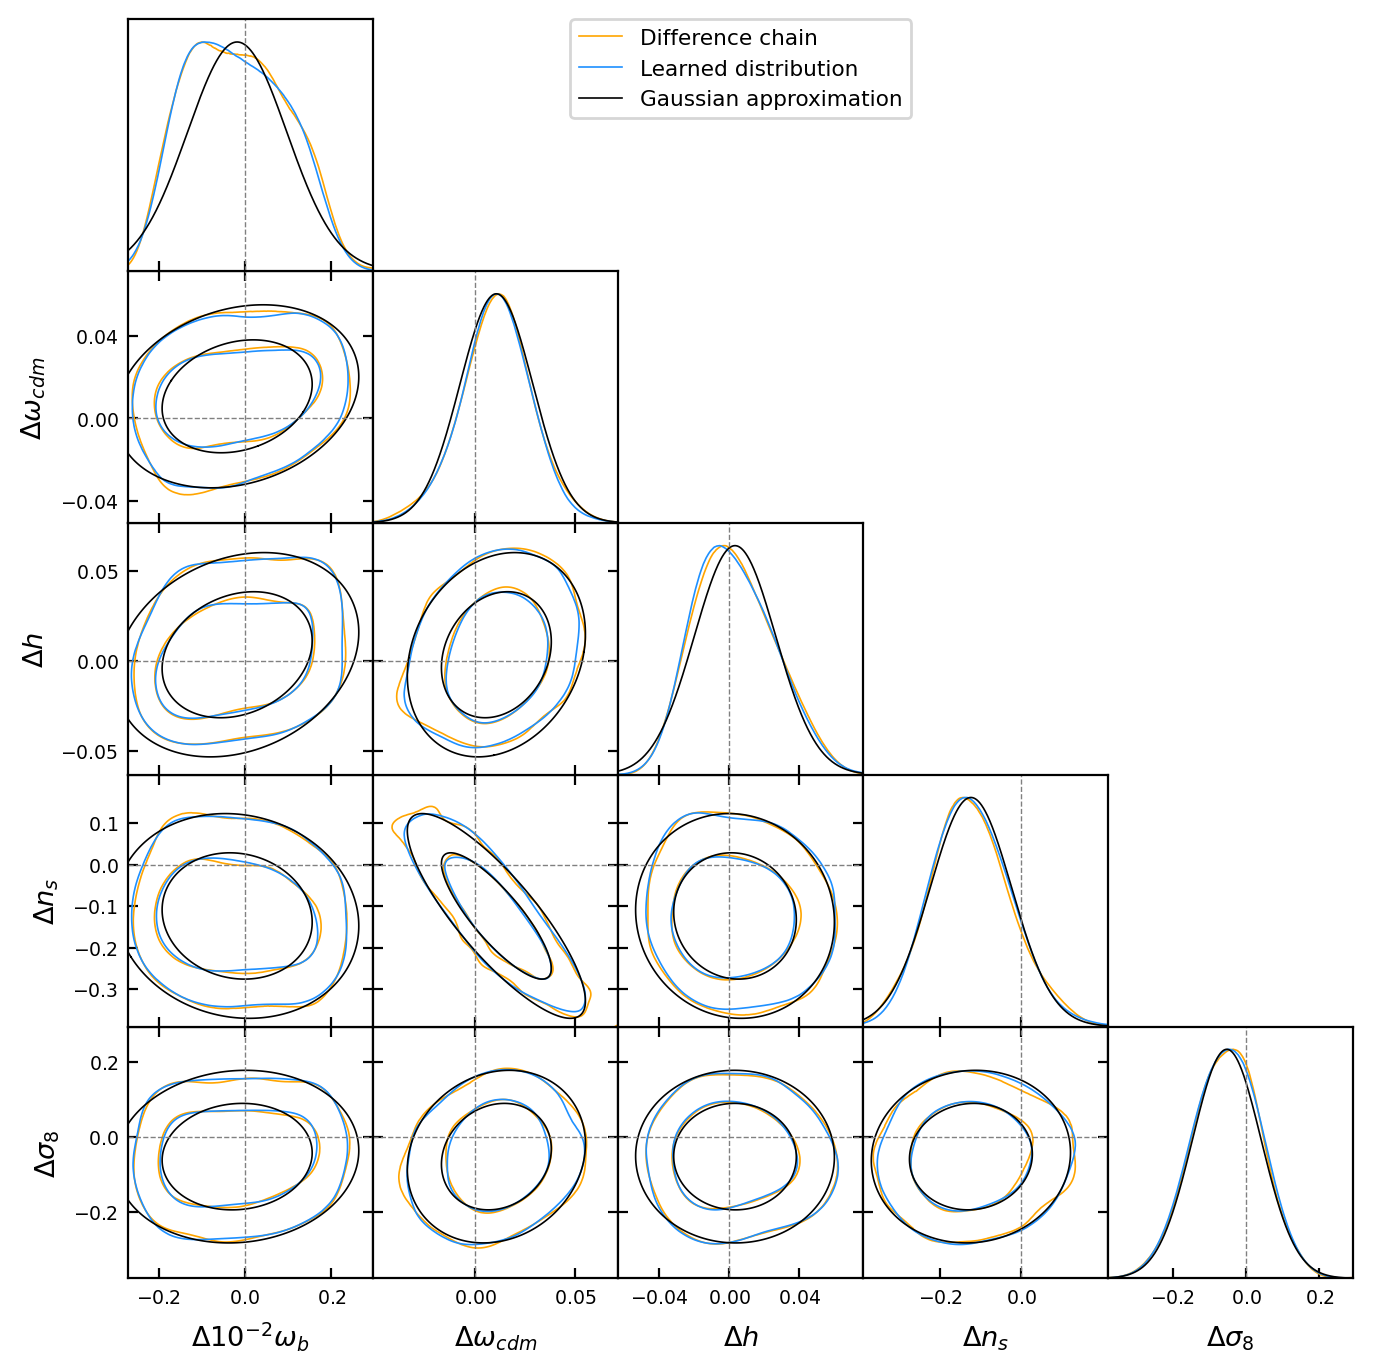

In [32]:
# Plot the learned and the approximated distributions, as well as the difference chain
flow.plot_distributions()

In [33]:
# Print the shift estimate, also in number of sigmas
flow.estimate_shift()

Considering ['delta_omega_b', 'delta_omega_cdm', 'delta_h', 'delta_n_s', 'delta_sigma8'] parameters...
Shift probability = 0.37618 + 0.00488 - 0.00485
          n_sigma = 0.490
